In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import ahpy
from matplotlib import rc # 차에 한국말 적기
from statsmodels.stats.outliers_influence import variance_inflation_factor # 다중공선성 문제
from sklearn.ensemble import RandomForestRegressor

rc('font', family='AppleGothic') 			
plt.rcParams['axes.unicode_minus'] = False

In [71]:
# 순위 reverse 칼럼 추가
data = pd.read_csv('./by_teams_baseball_popularity.csv')
data['rank_reverse'] = data['ranking'].apply(lambda x: 0 if x == 0 else data['ranking'].max() - x + 1)

# 결과 확인
print(data[['ranking', 'rank_reverse']].head())
data.to_csv('./by_teams_baseball_popularity.csv', index=False)

   ranking  rank_reverse
0        0             0
1        0             0
2        2             9
3        1            10
4        1            10


## 선형회귀

### 야구 인기도 분석을 위한 다른 칼럼 모색

In [162]:
data = pd.read_csv('./baseball_popularity_by_years.csv')

target = ['audience_by_year']
feature = ['article_counts_by_year', 'web_search_count_by_year', 'youtube_views_by_years', 'youtube_likes_by_years', 'youtube_comments_by_years']

X = data[feature]
y = data[target]

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 모델 불러오기
model = LinearRegression()
model.fit(X_scaled, y)

# 관중수 외 중요 칼럼 분석을 위한 회귀 계수 추출
coefficients = model.coef_
print(coefficients)
print(type(coefficients))


[[ -219915.81857318  1477806.76911926 -3382761.75245402  7708068.8336332
  -2959662.94650509]]
<class 'numpy.ndarray'>


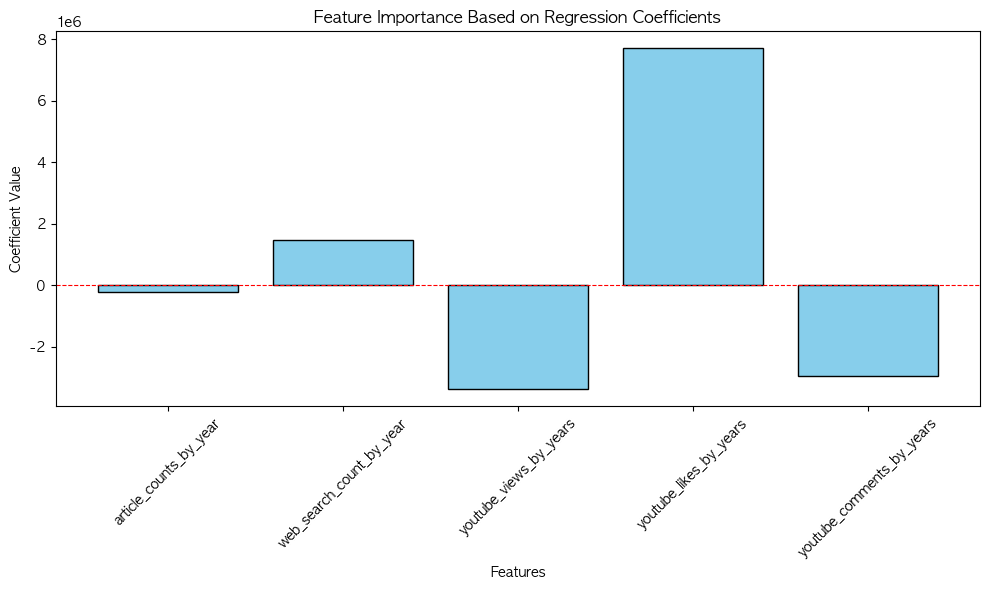

In [163]:

# 가중치를 바탕으로 그래프로 나타내기
feature_names = ['article_counts_by_year', 'web_search_count_by_year', 
                 'youtube_views_by_years', 'youtube_likes_by_years', 
                 'youtube_comments_by_years']

# 1D 배열로 변환
coefficients = coefficients.flatten() if hasattr(coefficients, 'flatten') else coefficients

# 선형 그래프 시각화
plt.figure(figsize=(10, 6))
plt.bar(feature_names, coefficients, color='skyblue', edgecolor='black')
plt.axhline(0, color='red', linewidth=0.8, linestyle='--')  # 기준선 (y=0)
plt.title('Feature Importance Based on Regression Coefficients')
plt.ylabel('Coefficient Value')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


- article_counts_by_year: 계수 -99405
→ 기사 수가 1 단위 증가하면 관중수는 약 99405명 감소할 가능성이 있음.
(다른 변수 고정 상태에서.)

- web_search_count_by_year: 계수 1471609
→ 웹 검색량이 1 단위 증가하면 관중수가 약 1471609명 증가.

- youtube_views_by_years: 계수 3507663
→ 유튜브 조회수가 1 단위 증가하면 관중수가 약 3507663명 증가.

- youtube_likes_by_years: 계수 -1545653
→ 유튜브 좋아요가 1 단위 증가하면 관중수가 약 1545653명 감소.

- youtube_comments_by_years: 계수 -427720
→ 유튜브 댓글 수가 1 단위 증가하면 관중수가 약 427720명 감소.

- 다중공선성: 조회수, 좋아요수, 댓글수의 서로 강한 상관관계(공선성)을 가지므로 일부 변수를 중요하게 여기지 않아 음의 계수를 할당할 수 있다.
- 따라서 다중공선성을 확인해보겠다 -> 일반적으로 상관계수가 0.8 이상이면 다중공선성이 의심

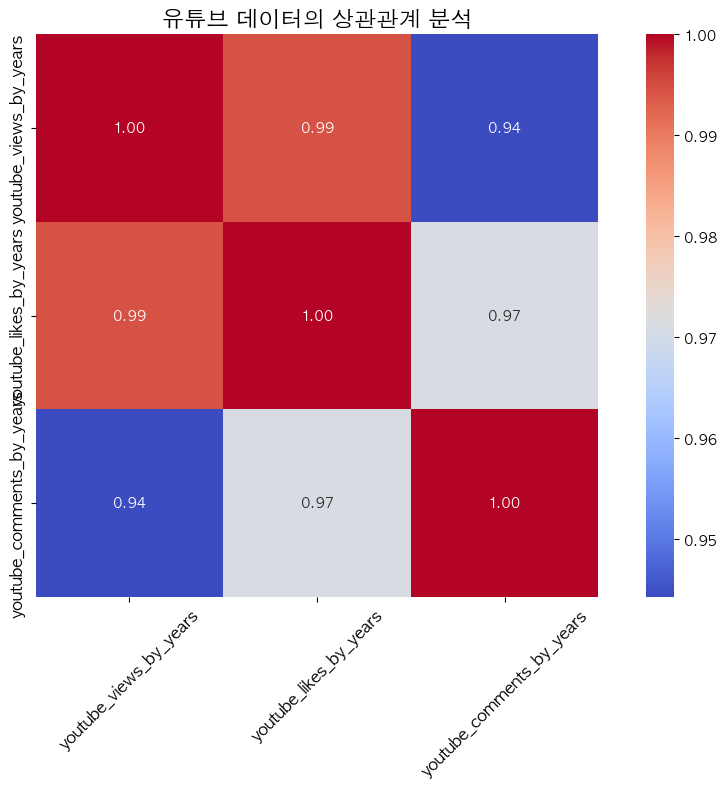

In [77]:
data = pd.read_csv('./baseball_popularity_by_years.csv')
# 스케일링할 칼럼 정의
features = ['youtube_views_by_years', 'youtube_likes_by_years', 'youtube_comments_by_years']

# 스케일링
X_scaled = MinMaxScaler().fit_transform(data[features])
scaled_df = pd.DataFrame(X_scaled, columns=features)

# 상관 행렬 계산
correlation_matrix = scaled_df.corr()

# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, square=True)
plt.title("유튜브 데이터의 상관관계 분석", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

- 분산 팽창 계수(VIF)를 통해서 다중공선성 확인
- VIF 1: 다중공선성이 없음
- VIF 1~5: 다중공선성이 약간 있음
- VIF 5 이상: 다중공선성이 심각

In [39]:


# Select relevant features for VIF calculation
features = ['article_counts_by_year', 'web_search_count_by_year', 'youtube_views_by_years', 'youtube_likes_by_years', 'youtube_comments_by_years']
X = data[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = features
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
vif_data

,Feature,VIF
0,article_counts_by_year,1.731441
1,web_search_count_by_year,1.705304
2,youtube_views_by_years,403.478505
3,youtube_likes_by_years,742.699860
4,youtube_comments_by_years,71.550160


- 분산 팽창 계수를 통해서 유튜브 데이터들은 굉장히 큰 상관관계를 가지고 있기 때문에 변수 제거 방식을 통해서 다중공선성 문제를 해결
- 따라서 기사수, 웹 검색량, 유튜브 조회수 칼럼을 바탕으로 분석해보겠다

[[-175809.98546657 1424824.06956428 1488445.4084833 ]]
<class 'numpy.ndarray'>


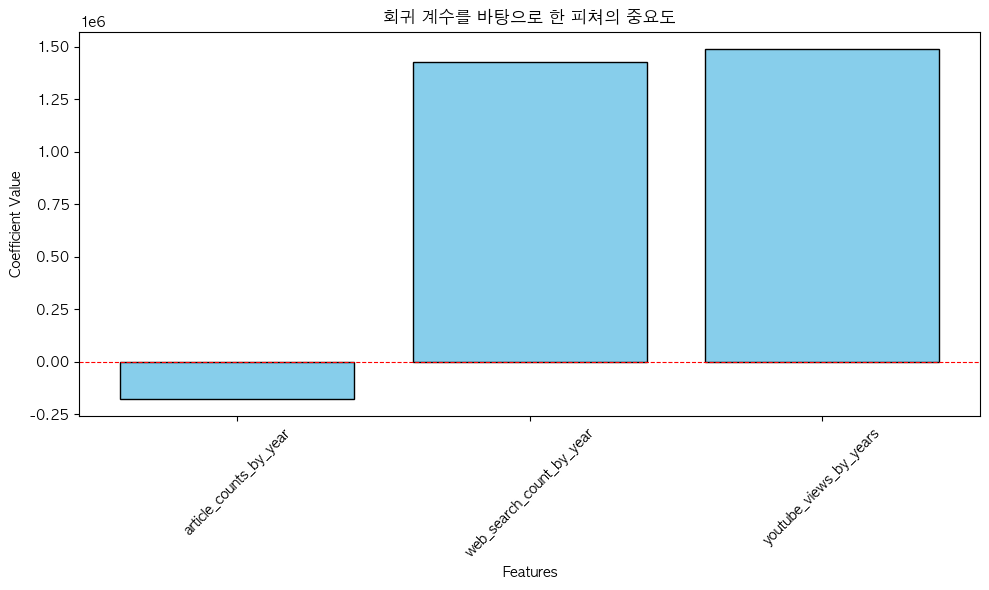

In [164]:
data = pd.read_csv('./baseball_popularity_by_years.csv')

target = ['audience_by_year']
feature = ['article_counts_by_year', 'web_search_count_by_year', 'youtube_views_by_years']

X = data[feature]
y = data[target]

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 모델 불러오기
model = LinearRegression()
model.fit(X_scaled, y)

# 관중수 외 중요 칼럼 분석을 위한 회귀 계수 추출
coefficients = model.coef_
print(coefficients)
print(type(coefficients))

feature_names = ['article_counts_by_year', 'web_search_count_by_year', 
                 'youtube_views_by_years']

# 1D 배열로 변환
coefficients_1d = coefficients.flatten() if hasattr(coefficients, 'flatten') else coefficients

# 선형 그래프 시각화
plt.figure(figsize=(10, 6))
plt.bar(feature_names, coefficients_1d, color='skyblue', edgecolor='black')
plt.axhline(0, color='red', linewidth=0.8, linestyle='--')  # 기준선 (y=0)
plt.title('회귀 계수를 바탕으로 한 피쳐의 중요도')
plt.ylabel('Coefficient Value')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

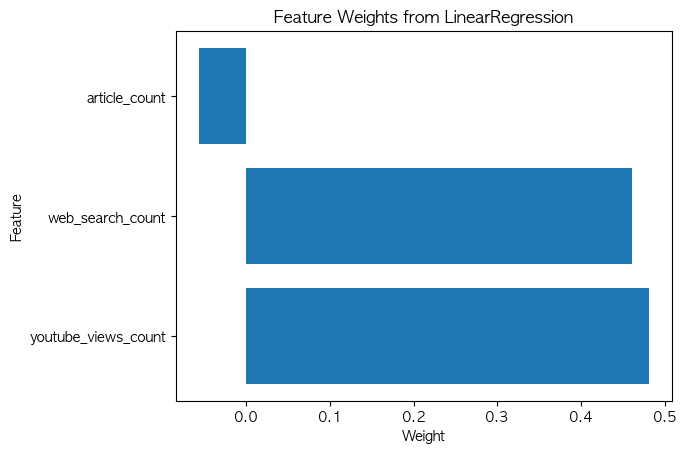

In [165]:
# 피쳐별 가중치 파일로 저장
coefficients = model.coef_
coefficients = coefficients.flatten() if len(coefficients.shape) > 1 else coefficients
feature_weights = coefficients / np.sum(np.abs(coefficients))

importance_df = pd.DataFrame({
    'Feature': ['article_count', 'web_search_count', 'youtube_views_count'],
    'Coefficient': coefficients,
    'Weight': feature_weights
}).sort_values(by='Coefficient', ascending=False)

importance_df.to_csv('reg_index_analysis_by_year.csv', index=False)

# 피처 중요도 시각화
plt.barh(importance_df['Feature'], importance_df['Weight'])
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.title('Feature Weights from LinearRegression')
plt.show()

### 구단별 야구 인기도에 미친 팀별 영향력 파악해보기

In [166]:
# 선형 회귀 방법이 연도별이었으므로 기준으로 2024년 1년치를 바탕으로 분석
by_teams_df = pd.read_csv('./by_teams_baseball_popularity.csv')
team_aggregated = by_teams_df.groupby('team')[
    ['article_count', 'audience_counts_by_teams', 'web_search_count', 'youtube_views']
].sum().reset_index()
team_aggregated.rename(columns={
    'article_count': 'article_count', 
    'audience_counts_by_teams': 'audience_by_year', 
    'web_search_count': 'web_search_count', 
    'youtube_views': 'youtube_views_count'
}, inplace=True)
team_aggregated.to_csv('./2024_by_teams_baseball_popularity.csv', index=False)


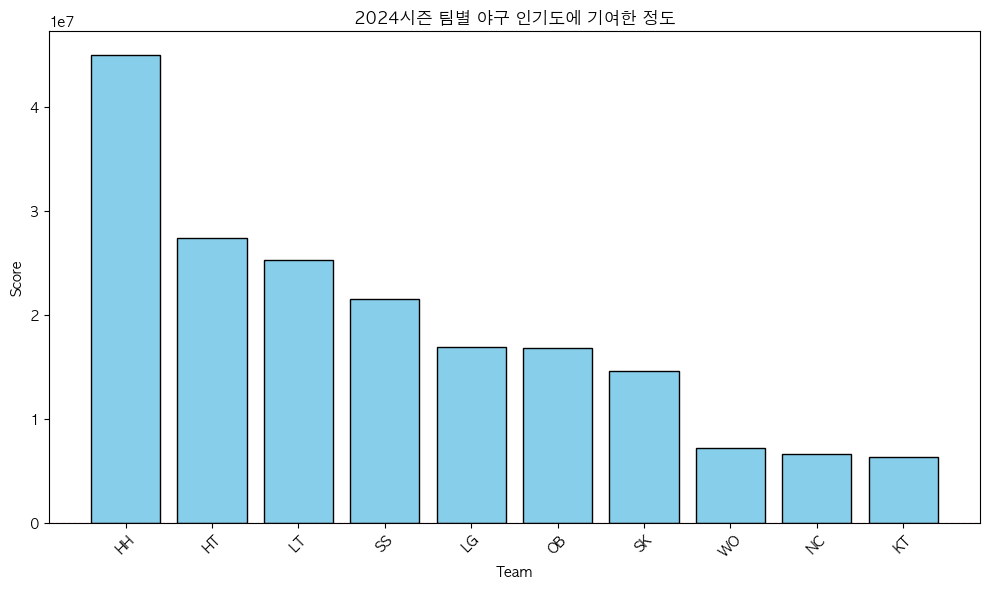

In [167]:
reg_index_path = 'reg_index_analysis_by_year.csv'
teams_2024_path = '2024_by_teams_baseball_popularity.csv'
reg_index_df = pd.read_csv(reg_index_path)
teams_2024_df = pd.read_csv(teams_2024_path)

# weight 불러오기
weights = reg_index_df.set_index('Feature')['Weight'].to_dict()

# teams_2024_path에서 weight에 있는 피쳐명 가져오기
relevant_features = [feature for feature in weights.keys() if feature in teams_2024_df.columns]

# Calculate weighted scores for each team
teams_2024_df['score'] = teams_2024_df[relevant_features].dot(
    np.array([weights[feature] for feature in relevant_features])
)

# 내림차순 정렬
teams_2024_df['rank'] = teams_2024_df['score'].rank(ascending=False)

ranked_teams_2024 = teams_2024_df[['team', 'score', 'rank']].sort_values(by='rank')

# 선형 그래프 시각화
plt.figure(figsize=(10, 6))
plt.bar(ranked_teams_2024['team'], ranked_teams_2024['score'], color='skyblue', edgecolor='black')
plt.axhline(0, color='red', linewidth=0.8, linestyle='--')  # 기준선 (y=0)
plt.title('2024시즌 팀별 야구 인기도에 기여한 정도')
plt.ylabel('Score')
plt.xlabel('Team')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



- 여기에 순위 지표까지 넣게 된다면?

[[ -21769.17827349  117065.77685978   66967.85602077 -269728.24151044]]
<class 'numpy.ndarray'>


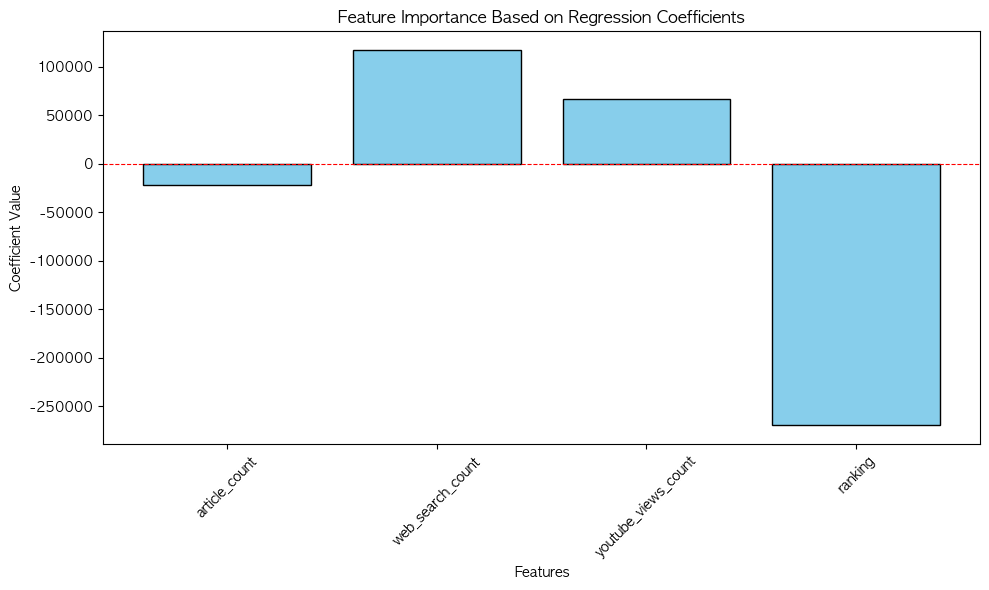

In [168]:
teams_data = pd.read_csv('./2024_by_teams_baseball_popularity.csv')
team_ranks = {
    'HT': 1,
    'SS': 2,
    'LG': 3,
    'OB': 4,
    'KT': 5,
    'SK': 6,
    'LT': 7,
    'HH': 8,
    'NC': 9,
    'WO': 10
}

# rank 칼럼 추가
teams_data['ranking'] = teams_data['team'].map(team_ranks)
teams_data['rank_reverse'] = teams_data['ranking'].apply(lambda x: 0 if x == 0 else teams_data['ranking'].max() - x + 1)
teams_data.to_csv('./2024_rank_by_teams_baseball_popularity.csv', index=False)

target = ['audience_by_year']
feature = ['article_count', 'web_search_count', 'youtube_views_count', 'ranking']

X = teams_data[feature]
y = teams_data[target]

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 모델 불러오기
model = LinearRegression()
model.fit(X_scaled, y)

# 관중수 외 중요 칼럼 분석을 위한 회귀 계수 추출
coefficients = model.coef_
print(coefficients)
print(type(coefficients))

feature_names = ['article_count', 'web_search_count', 'youtube_views_count', 'ranking']

# 1D 배열로 변환
coefficients_1d = coefficients.flatten() if hasattr(coefficients, 'flatten') else coefficients

# 선형 그래프 시각화
plt.figure(figsize=(10, 6))
plt.bar(feature_names, coefficients_1d, color='skyblue', edgecolor='black')
plt.axhline(0, color='red', linewidth=0.8, linestyle='--')  # 기준선 (y=0)
plt.title('Feature Importance Based on Regression Coefficients')
plt.ylabel('Coefficient Value')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

  team  contribution
0   HH  6.263543e+12
1   HT  3.810464e+12
4   LT  3.524592e+12
8   SS  2.993638e+12
3   LG  2.351379e+12
6   OB  2.347252e+12
7   SK  2.030190e+12
9   WO  1.005104e+12
5   NC  9.311457e+11
2   KT  8.798295e+11


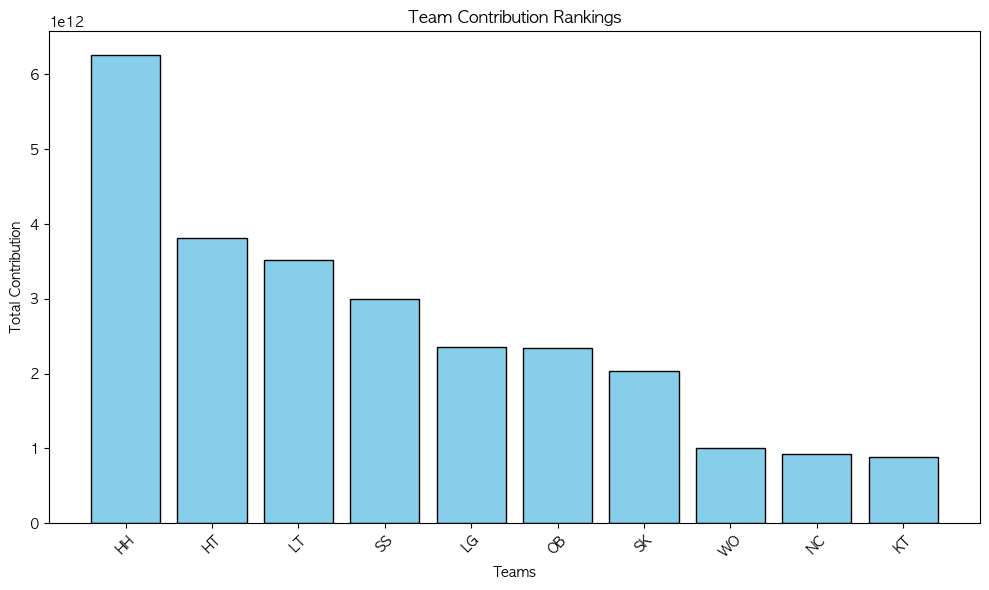

In [169]:
teams_data['contribution'] = teams_data[feature_names].dot(coefficients_1d)

# 팀별 총 기여도 순위 계산
team_contributions = teams_data.groupby('team')['contribution'].sum().reset_index()
team_contributions = team_contributions.sort_values(by='contribution', ascending=False)
print(team_contributions)

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(team_contributions['team'], team_contributions['contribution'], color='skyblue', edgecolor='black')
plt.title('Team Contribution Rankings')
plt.ylabel('Total Contribution')
plt.xlabel('Teams')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## AHP

- 행정학이나 정책학의 분석기법중 하나로 다수의 속성들을 계층적으로 분류하여 각 속성의 중요도를 파악함으로써 최적의 대안을 선정하는 기법이다.
- 해당 분석 기법의 경우 타겟값이 있고, 타겟값과의 관계성을 분석하는 것이므로 요소 간의 중요도를 비교하기 위해 사용되는 AHP 기법은 옳지 않을 수 있다.

## XGBoost

- 앙상블의 기법으로 많은 칼럼을 가지고 있는 경우 용이한 모델이나 내가 가지고 있는 데이터의 경우 데이터 자체로는 많지 않기 때문에 부적합하다고 판단하였다.

## EDA 및 상관 관계 분석

In [63]:
data = pd.read_csv('./baseball_popularity_by_years.csv')
data

,year,audience_by_year,article_counts_by_year,web_search_count_by_year,youtube_views_by_years,youtube_likes_by_years,youtube_comments_by_years
0,2010,5928626,107644,579,0,0,0
1,2011,6810028,172803,1091,0,0,0
2,2012,7156157,278297,1031,0,0,0
3,2013,6441945,299639,846,0,0,0
4,2014,6509915,290800,689,0,0,0
5,2015,7360530,283386,920,102705,337,39
6,2016,8339577,129755,704,1549632,7500,640
7,2017,8400688,131209,860,48283,326,22
8,2018,8073742,113978,763,4486869,24065,1468
9,2019,7286008,107400,601,477399,4220,313


In [72]:
data = pd.read_csv('./2024_rank_by_teams_baseball_popularity.csv')
data.head(12)

,team,article_count,audience_by_year,web_search_count,youtube_views_count,ranking,rank_reverse
0,HH,8752,804204,3085,93528076.0,8,3
1,HT,12962,1259249,1823,56900930.0,1,10
2,KT,5678,843942,3214,13134334.0,5,6
3,LG,9125,1397499,3574,35108779.0,3,8
4,LT,6949,1202840,3204,52627787.0,7,4
5,NC,3850,731167,3368,13899768.0,9,2
6,OB,6715,1301768,3625,35046297.0,4,7
7,SK,3666,1143773,3508,30310968.0,6,5
8,SS,9917,1347022,3188,44700268.0,2,9
9,WO,3397,808349,4106,15002719.0,10,1


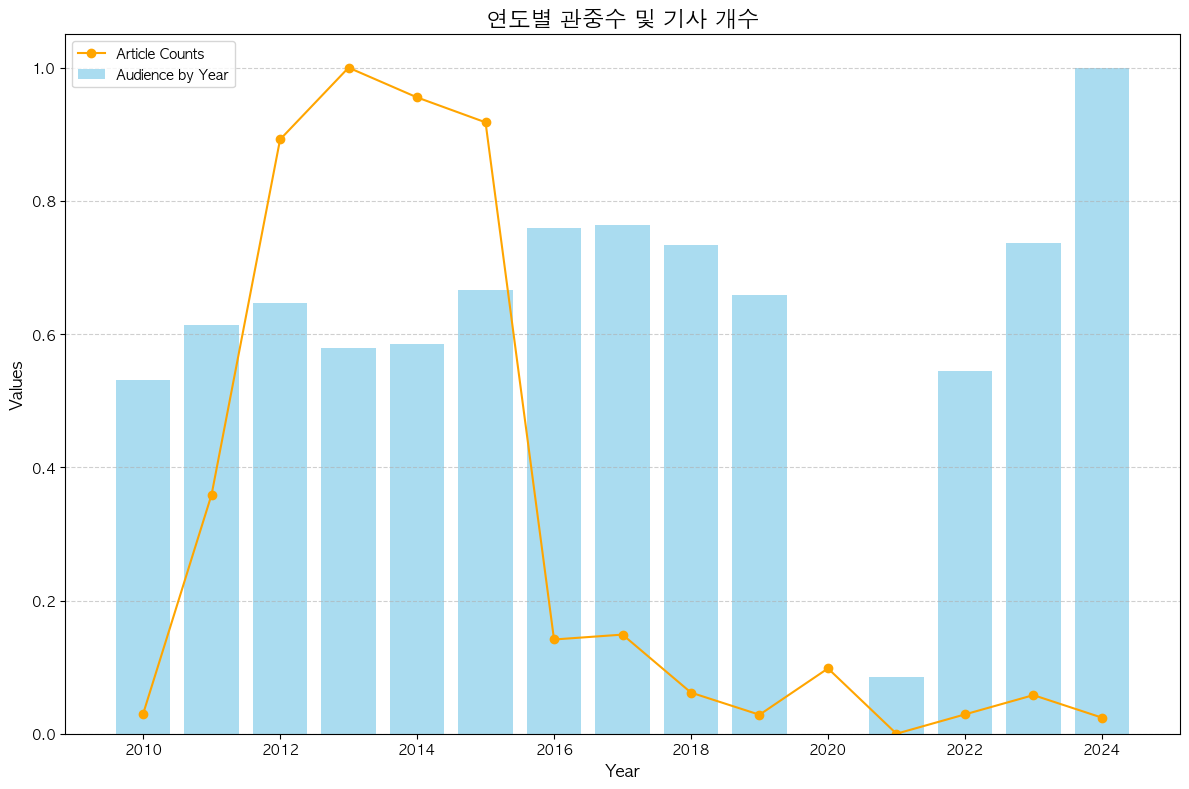

In [4]:
data = pd.read_csv('./baseball_popularity_by_years.csv')

# 스케일링 수행
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.iloc[:, 1:])  # year 제외
scaled_df = pd.DataFrame(scaled_data, columns=data.columns[1:])  # 스케일링 결과 DataFrame
scaled_df['year'] = data['year']  # 원래 연도 정보 추가

# 연도별 관중수와 다른 칼럼을 동시에 시각화
plt.figure(figsize=(12, 8))

# 관중수를 막대그래프로 시각화
plt.bar(scaled_df['year'], scaled_df['audience_by_year'], color='skyblue', alpha=0.7, label='Audience by Year')

# 다른 칼럼들의 선그래프 추가
plt.plot(scaled_df['year'], scaled_df['article_counts_by_year'], color='orange', marker='o', label='Article Counts')

# 그래프 꾸미기
plt.title('연도별 관중수 및 기사 개수', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# 그래프 출력
plt.show()

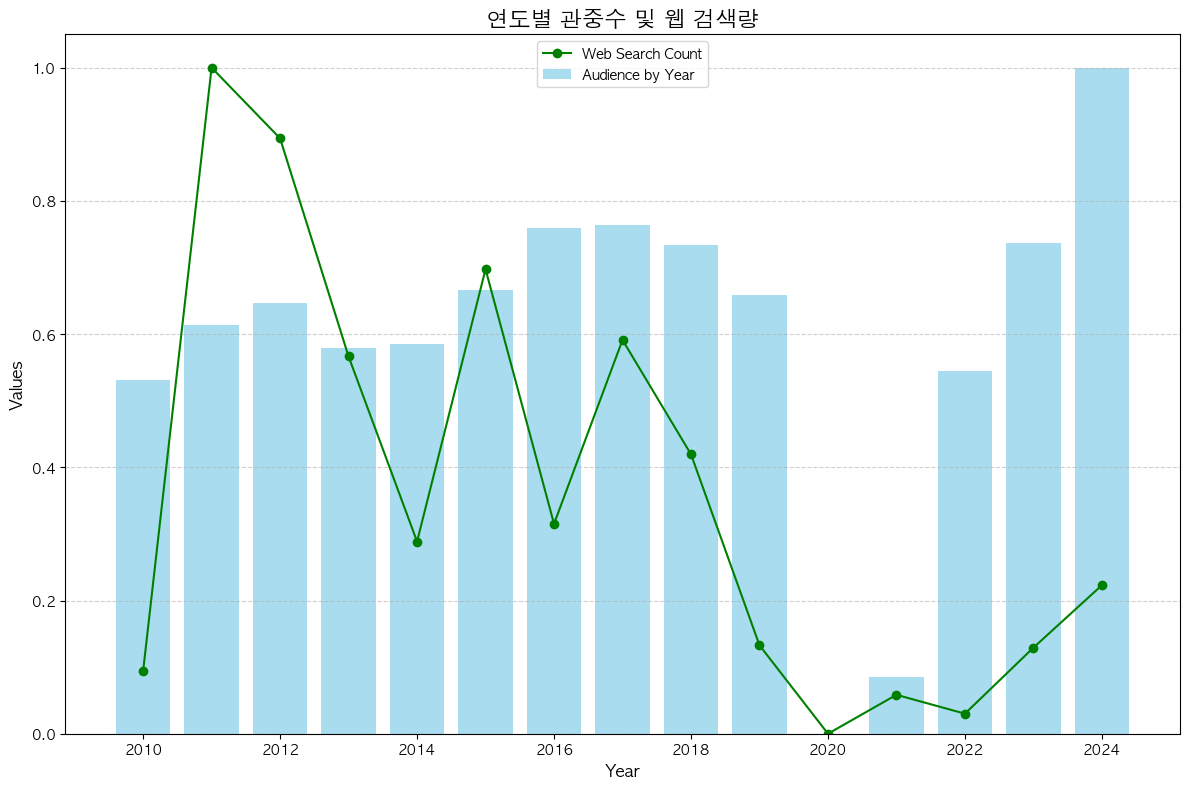

In [6]:
data = pd.read_csv('./baseball_popularity_by_years.csv')

# 스케일링 수행
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.iloc[:, 1:])  # year 제외
scaled_df = pd.DataFrame(scaled_data, columns=data.columns[1:])  # 스케일링 결과 DataFrame
scaled_df['year'] = data['year']  # 원래 연도 정보 추가

# 연도별 관중수와 다른 칼럼을 동시에 시각화
plt.figure(figsize=(12, 8))

# 관중수를 막대그래프로 시각화
plt.bar(scaled_df['year'], scaled_df['audience_by_year'], color='skyblue', alpha=0.7, label='Audience by Year')

# 다른 칼럼들의 선그래프 추가
plt.plot(scaled_df['year'], scaled_df['web_search_count_by_year'], color='green', marker='o', label='Web Search Count')

# 그래프 꾸미기
plt.title('연도별 관중수 및 웹 검색량', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# 그래프 출력
plt.show()

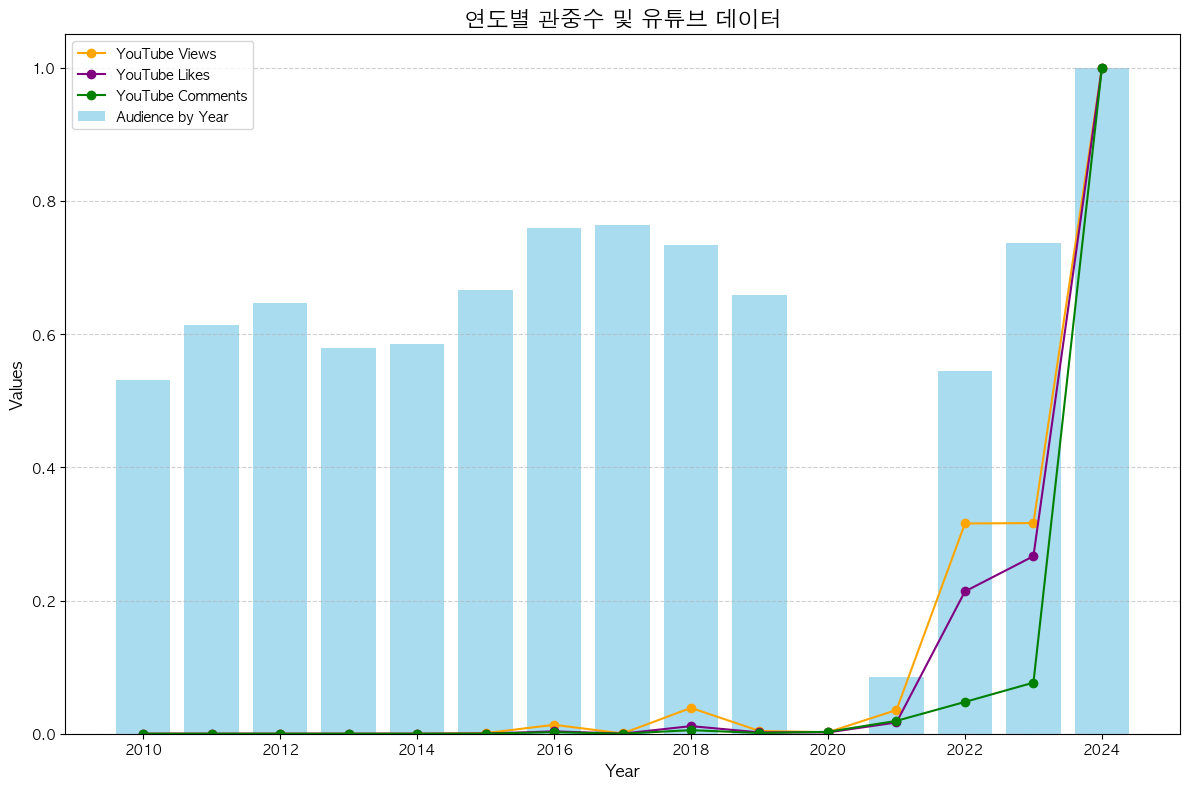

In [7]:
data = pd.read_csv('./baseball_popularity_by_years.csv')

# 스케일링 수행
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.iloc[:, 1:])  # year 제외
scaled_df = pd.DataFrame(scaled_data, columns=data.columns[1:])  # 스케일링 결과 DataFrame
scaled_df['year'] = data['year']  # 원래 연도 정보 추가

# 연도별 관중수와 다른 칼럼을 동시에 시각화
plt.figure(figsize=(12, 8))

# 관중수를 막대그래프로 시각화
plt.bar(scaled_df['year'], scaled_df['audience_by_year'], color='skyblue', alpha=0.7, label='Audience by Year')

# 다른 칼럼들의 선그래프 추가
plt.plot(scaled_df['year'], scaled_df['youtube_views_by_years'], color='orange', marker='o', label='YouTube Views')
plt.plot(scaled_df['year'], scaled_df['youtube_likes_by_years'], color='purple', marker='o', label='YouTube Likes')
plt.plot(scaled_df['year'], scaled_df['youtube_comments_by_years'], color='green', marker='o', label='YouTube Comments')

# 그래프 꾸미기
plt.title('연도별 관중수 및 유튜브 데이터', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# 그래프 출력
plt.show()

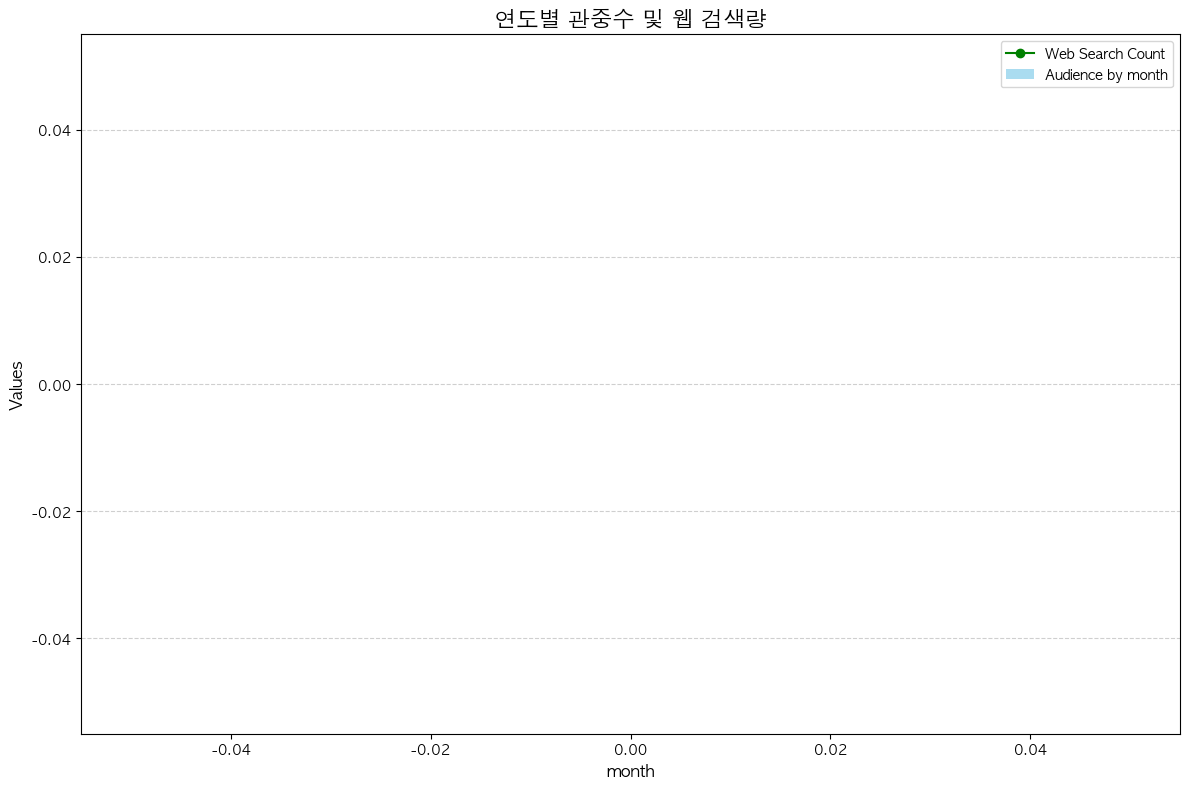

In [11]:
data = pd.read_csv('./by_teams_baseball_popularity.csv')
data = data[data['team'] == 'OB']

# 스케일링 수행
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.iloc[:, 2:])  # year 제외
scaled_df = pd.DataFrame(scaled_data, columns=data.columns[2:])  # 스케일링 결과 DataFrame
scaled_df['month'] = data['month']  # 원래 연도 정보 추가

# 연도별 관중수와 다른 칼럼을 동시에 시각화
plt.figure(figsize=(12, 8))

# 관중수를 막대그래프로 시각화
plt.bar(scaled_df['month'], scaled_df['audience_counts_by_teams'], color='skyblue', alpha=0.7, label='Audience by month')

# 다른 칼럼들의 선그래프 추가
plt.plot(scaled_df['month'], scaled_df['web_search_count'], color='green', marker='o', label='Web Search Count')

# 그래프 꾸미기
plt.title('연도별 관중수 및 웹 검색량', fontsize=16)
plt.xlabel('month', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# 그래프 출력
plt.show()

### 피어슨 상관관계

- 연속형 데이터와 정규성을 만족해야되지만 내 데이터는 정규성을 만족하지 않으므로 사용할 수 없다.

### 켄달의 상관계수

- 상관관계 분석: 켄달의 상관계수(두 변수 사이의 상관관계의 정도를 나타내는 지표/한 변수가 증가할 때 다른 변수도 증가하는 횟수와 감소하는 횟수를 전체적으로 측정하여 그 차이를 분석하여 상관계수로 표현)
- -1 ~ 1 사이의 값을 갖는데 절댓값이 커질수록 예측할 수 있는 정도가 높아진다.
- 1에 가까워지면 양의 상관관계
- -1에 가까워지면 음의 상관관계

In [149]:
data = pd.read_csv('./baseball_popularity_by_years.csv')

target_column = 'audience_by_year'
other_columns = [col for col in data.columns if col != target_column and col != 'year']

# 결과 저장
correlation_results = {}

# 각 칼럼과 target_column 간의 켄달 상관 계수 계산
for col in other_columns:
    correlation, p_value = kendalltau(data[target_column], data[col])
    correlation_results[col] = {'Kendall Correlation': correlation, 'P-value': p_value}

# 결과를 데이터프레임으로 변환하여 보기 좋게 출력
correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index')
correlation_df


,Kendall Correlation,P-value
article_counts_by_year,-0.028571,0.922570
web_search_count_by_year,0.295238,0.139463
youtube_views_by_years,0.290363,0.142827
youtube_likes_by_years,0.270338,0.172478
youtube_comments_by_years,0.230288,0.245167


- p-value 값이 0.05 이하인 칼럼이 없으므로 해당 데이터는 유의미하지 않는다.

### 거리 기반 상관계수

- 복잡한 관계를 찾기 위한 방식이지만.. 내 데이터는 복잡하지 않음

### 구단별 데이터 분석

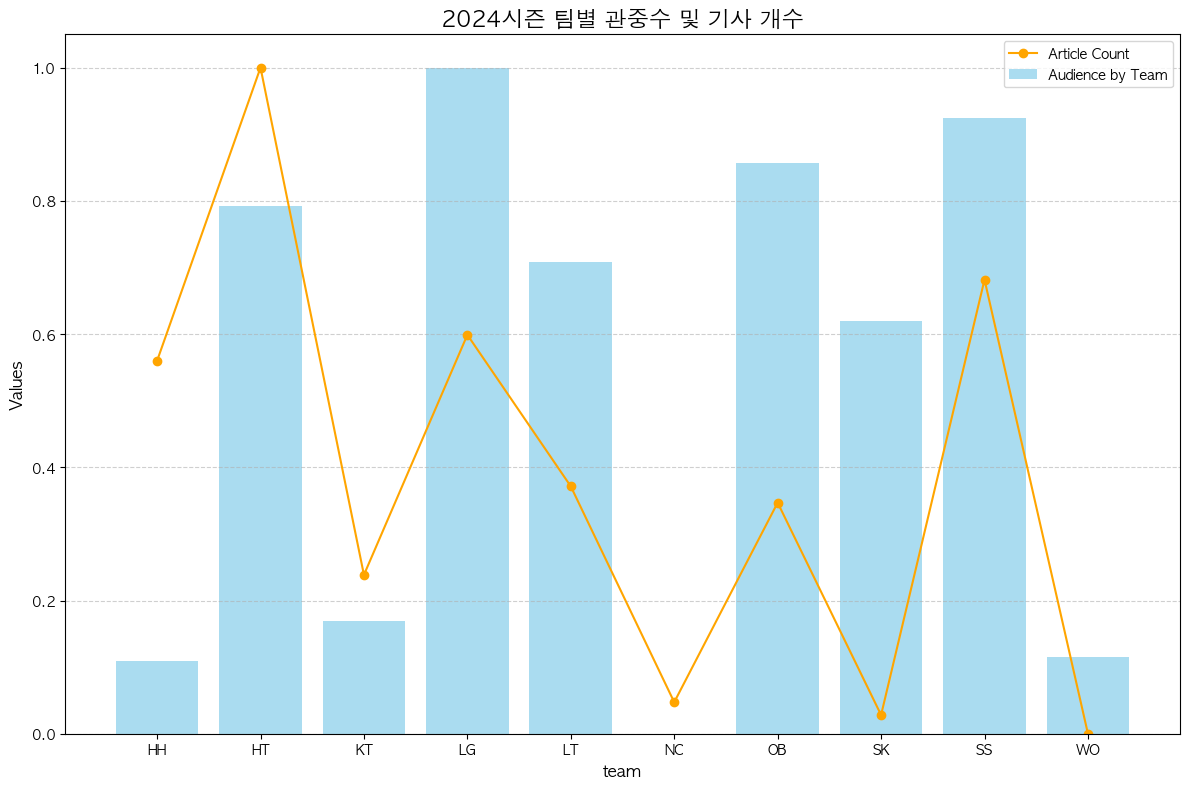

In [61]:
data = pd.read_csv('./2024_rank_by_teams_baseball_popularity.csv')

# 스케일링 수행
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.iloc[:, 1:])  # year 제외
scaled_df = pd.DataFrame(scaled_data, columns=data.columns[1:])  # 스케일링 결과 DataFrame
scaled_df['team'] = data['team']  # 원래 연도 정보 추가

# 연도별 관중수와 다른 칼럼을 동시에 시각화
plt.figure(figsize=(12, 8))

# 관중수를 막대그래프로 시각화
plt.bar(scaled_df['team'], scaled_df['audience_by_year'], color='skyblue', alpha=0.7, label='Audience by Team')

# 다른 칼럼들의 선그래프 추가
plt.plot(scaled_df['team'], scaled_df['article_count'], color='orange', marker='o', label='Article Count')

# 그래프 꾸미기
plt.title('2024시즌 팀별 관중수 및 기사 개수', fontsize=16)
plt.xlabel('team', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# 그래프 출력
plt.show()

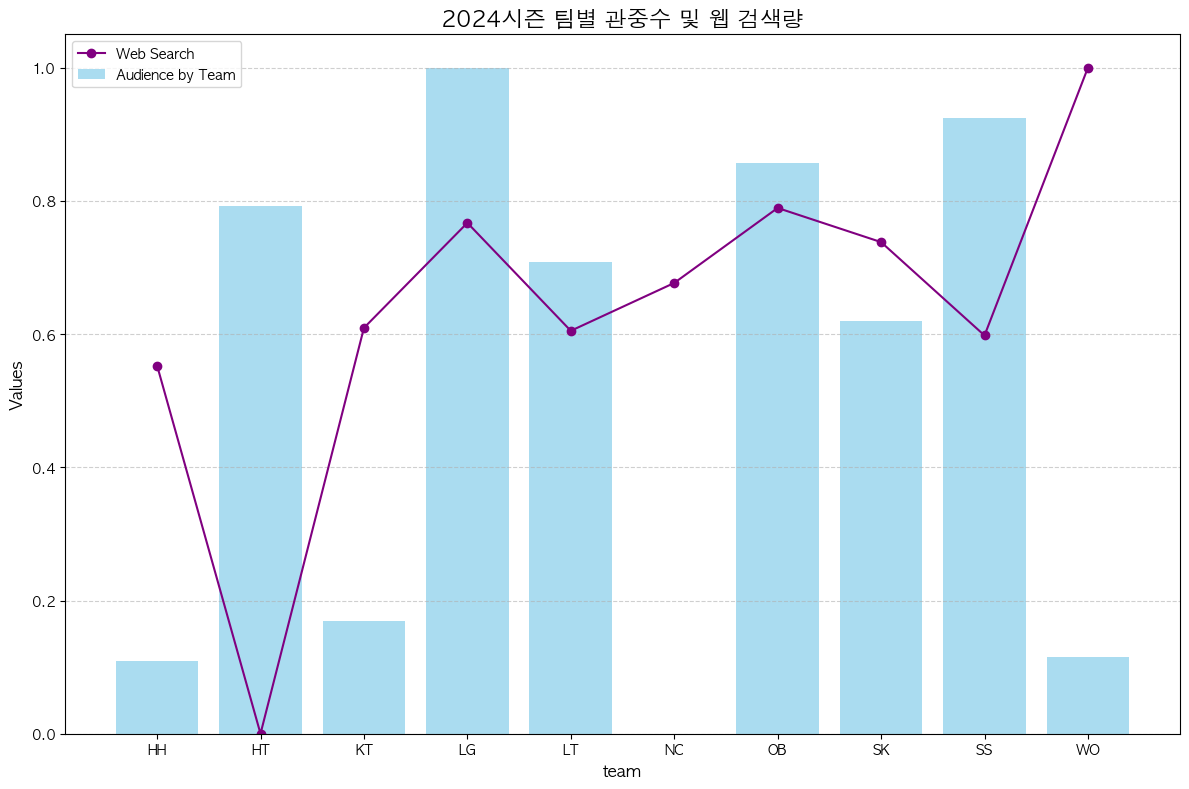

In [62]:
data = pd.read_csv('./2024_rank_by_teams_baseball_popularity.csv')

# 스케일링 수행
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.iloc[:, 1:])  # year 제외
scaled_df = pd.DataFrame(scaled_data, columns=data.columns[1:])  # 스케일링 결과 DataFrame
scaled_df['team'] = data['team']  # 원래 연도 정보 추가

# 연도별 관중수와 다른 칼럼을 동시에 시각화
plt.figure(figsize=(12, 8))

# 관중수를 막대그래프로 시각화
plt.bar(scaled_df['team'], scaled_df['audience_by_year'], color='skyblue', alpha=0.7, label='Audience by Team')

# 다른 칼럼들의 선그래프 추가
plt.plot(scaled_df['team'], scaled_df['web_search_count'], color='purple', marker='o', label='Web Search')

# 그래프 꾸미기
plt.title('2024시즌 팀별 관중수 및 웹 검색량', fontsize=16)
plt.xlabel('team', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# 그래프 출력
plt.show()

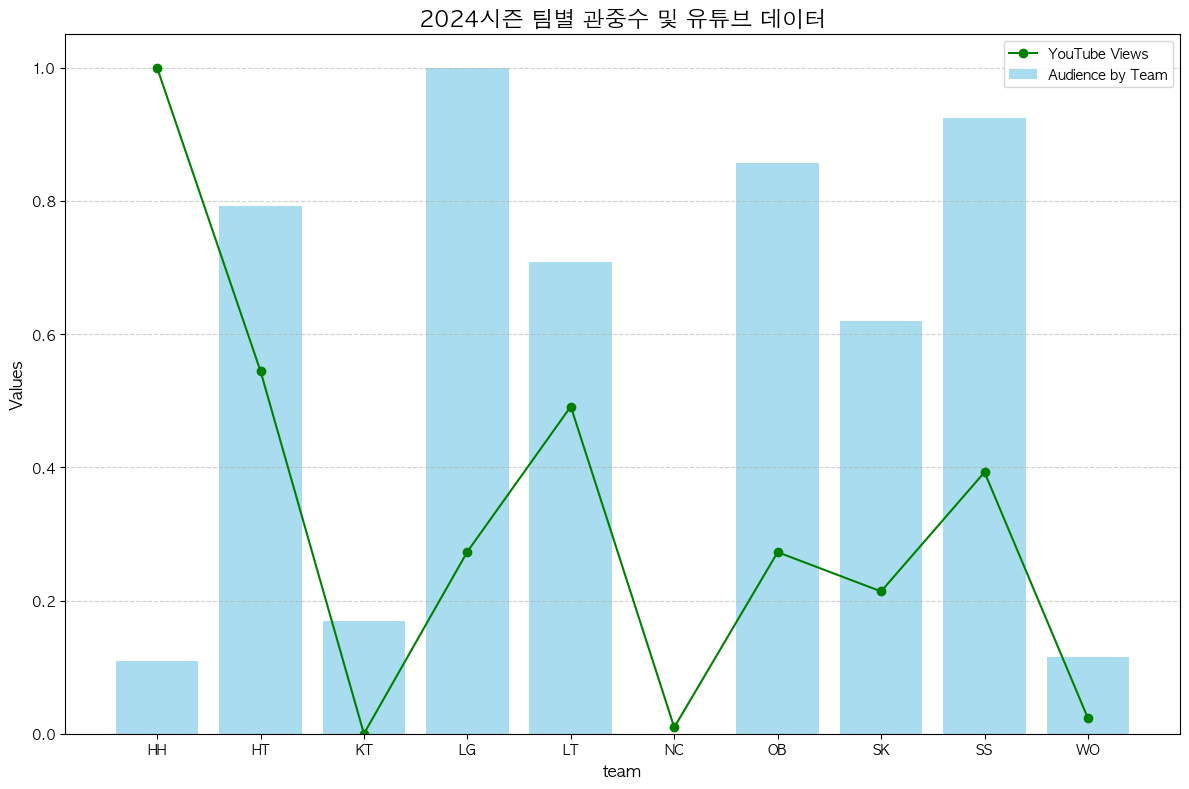

In [63]:
data = pd.read_csv('./2024_rank_by_teams_baseball_popularity.csv')

# 스케일링 수행
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.iloc[:, 1:])  # year 제외
scaled_df = pd.DataFrame(scaled_data, columns=data.columns[1:])  # 스케일링 결과 DataFrame
scaled_df['team'] = data['team']  # 원래 연도 정보 추가

# 연도별 관중수와 다른 칼럼을 동시에 시각화
plt.figure(figsize=(12, 8))

# 관중수를 막대그래프로 시각화
plt.bar(scaled_df['team'], scaled_df['audience_by_year'], color='skyblue', alpha=0.7, label='Audience by Team')

# 다른 칼럼들의 선그래프 추가
plt.plot(scaled_df['team'], scaled_df['youtube_views_count'], color='green', marker='o', label='YouTube Views')

# 그래프 꾸미기
plt.title('2024시즌 팀별 관중수 및 유튜브 데이터', fontsize=16)
plt.xlabel('team', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# 그래프 출력
plt.show()

0    0.559854
1    1.000000
2    0.238474
3    0.598850
4    0.371354
5    0.047360
6    0.346890
7    0.028123
8    0.681652
9    0.000000
Name: article_count, dtype: float64


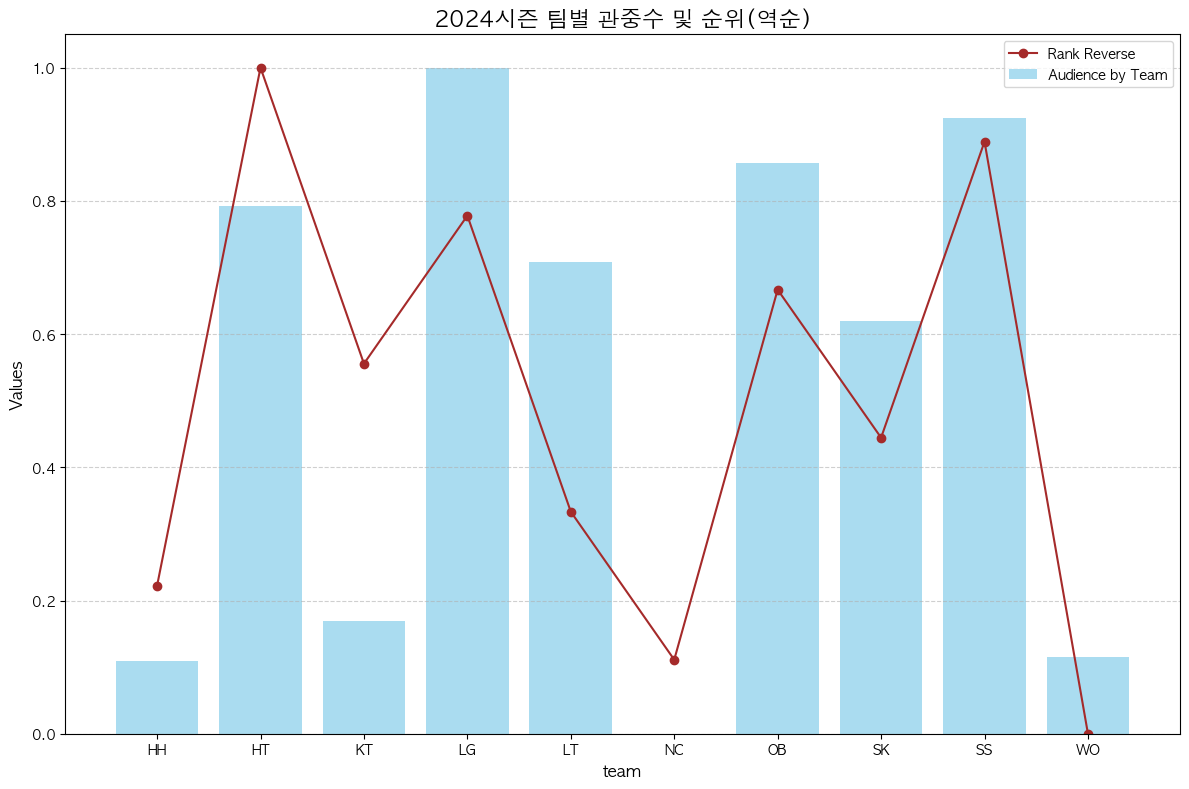

In [64]:
data = pd.read_csv('./2024_rank_by_teams_baseball_popularity.csv')

# 스케일링 수행
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.iloc[:, 1:])  # year 제외
scaled_df = pd.DataFrame(scaled_data, columns=data.columns[1:])  # 스케일링 결과 DataFrame
scaled_df['team'] = data['team']  # 원래 연도 정보 추가
print(scaled_df['article_count'])
# 연도별 관중수와 다른 칼럼을 동시에 시각화
plt.figure(figsize=(12, 8))

# 관중수를 막대그래프로 시각화
plt.bar(scaled_df['team'], scaled_df['audience_by_year'], color='skyblue', alpha=0.7, label='Audience by Team')

# 다른 칼럼들의 선그래프 추가
plt.plot(scaled_df['team'], scaled_df['rank_reverse'], color='brown', marker='o', label='Rank Reverse')

# 그래프 꾸미기
plt.title('2024시즌 팀별 관중수 및 순위(역순)', fontsize=16)
plt.xlabel('team', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# 그래프 출력
plt.show()

## 랜덤 포레스트

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


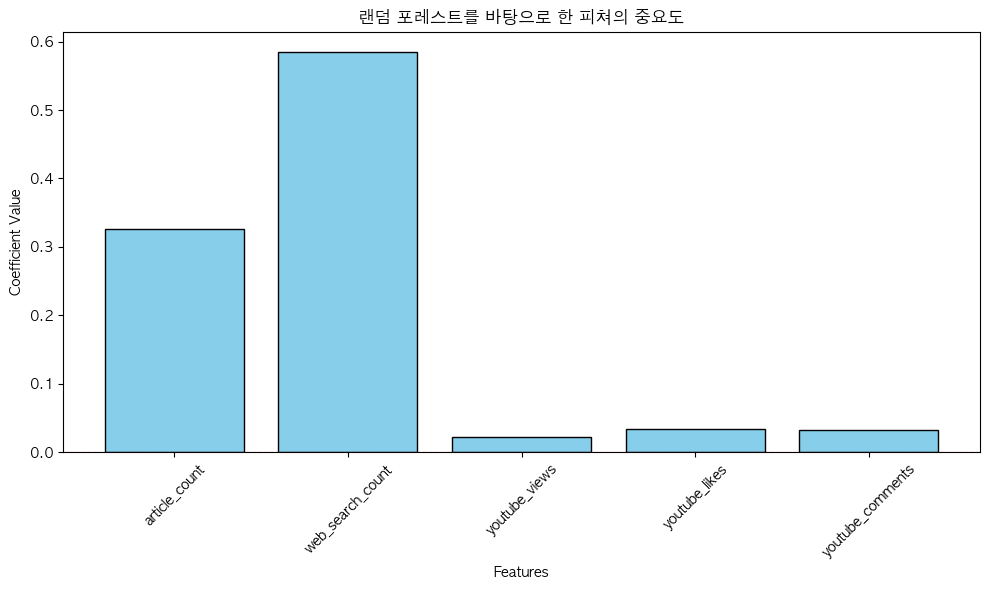

In [17]:

data = pd.read_csv('./baseball_popularity_by_years.csv')

# 타겟과 피쳐 정의
target = ['audience_by_year']
feature = ['article_counts_by_year', 'web_search_count_by_year', 'youtube_views_by_years', 'youtube_likes_by_years', 'youtube_comments_by_years']

X = data[feature]
y = data[target] 

# 타겟 변수 로그 변환
y_log = np.log1p(y)  # 로그 변환 (log(1 + y)로 음수 값 방지)

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_scaled, y_log)

feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': ['article_count', 'web_search_count', 'youtube_views', 'youtube_likes', 'youtube_comments'],
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
# 가중치 저장
importance_df.to_csv('rf_index_analysis_by_year.csv', index=False)

plt.figure(figsize=(10, 6))
plt.bar(['article_count', 'web_search_count', 'youtube_views', 'youtube_likes', 'youtube_comments'], feature_importances, color='skyblue', edgecolor='black')
plt.axhline(0, color='red', linewidth=0.8, linestyle='--')  # 기준선 (y=0)
plt.title('랜덤 포레스트를 바탕으로 한 피쳐의 중요도')
plt.ylabel('Coefficient Value')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 구단별 야구 인기도에 미친 팀별 영향력 파악해보기

In [3]:
# 랜덤 포레스트 방법이 연도별이었으므로 기준으로 2024년 1년치를 바탕으로 분석
by_teams_df = pd.read_csv('./by_teams_baseball_popularity.csv')
team_aggregated = by_teams_df.groupby('team')[
    ['article_count', 'audience_counts_by_teams', 'web_search_count', 'youtube_views', 'youtube_likes', 'youtube_comments']
].sum().reset_index()

team_aggregated.to_csv('./2024_all_by_teams_baseball_popularity.csv', index=False)

  team         score  rank
0   HH  2.141563e+06   1.0
1   HT  1.317291e+06   2.0
4   LT  1.221089e+06   3.0
8   SS  1.051296e+06   4.0
3   LG  8.313196e+05   5.0
6   OB  8.206985e+05   6.0
7   SK  7.112408e+05   7.0
9   WO  3.568093e+05   8.0
5   NC  3.312770e+05   9.0
2   KT  3.093330e+05  10.0


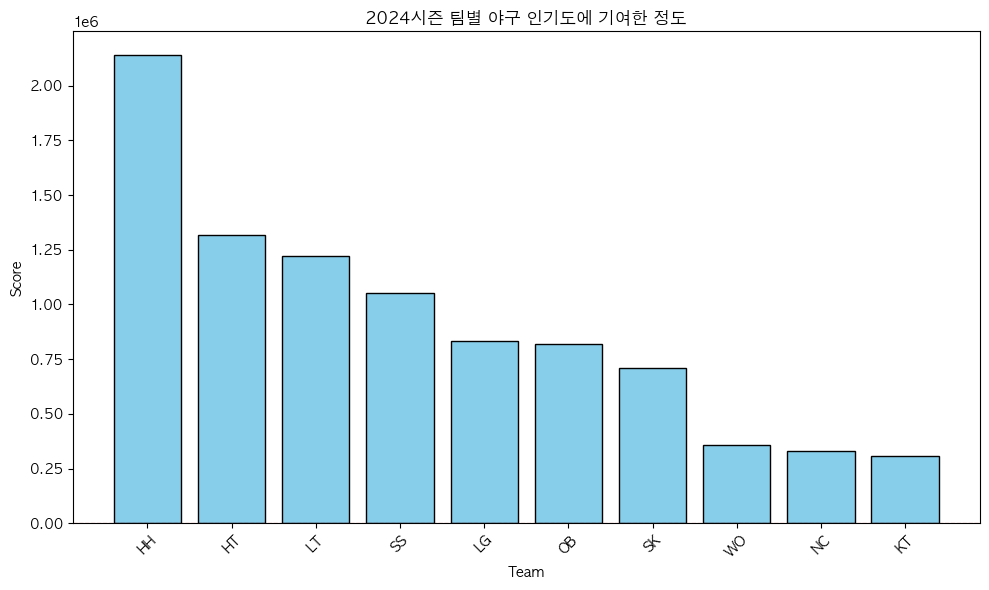

In [7]:
rf_index_path = 'rf_index_analysis_by_year.csv'

teams_2024_path = '2024_all_by_teams_baseball_popularity.csv'
rf_index_df = pd.read_csv(rf_index_path)
teams_2024_df = pd.read_csv(teams_2024_path)

# weight 불러오기
weights = rf_index_df.set_index('Feature')['Importance'].to_dict()

# teams_2024_path에서 weight에 있는 피쳐명 가져오기
relevant_features = [feature for feature in weights.keys() if feature in teams_2024_df.columns]

# Calculate weighted scores for each team
teams_2024_df['score'] = teams_2024_df[relevant_features].dot(
    np.array([weights[feature] for feature in relevant_features])
)

# 내림차순 정렬
teams_2024_df['rank'] = teams_2024_df['score'].rank(ascending=False)
ranked_teams_2024 = teams_2024_df[['team', 'score', 'rank']].sort_values(by='rank')
print(ranked_teams_2024)
# 선형 그래프 시각화
plt.figure(figsize=(10, 6))
plt.bar(ranked_teams_2024['team'], ranked_teams_2024['score'], color='skyblue', edgecolor='black')
plt.axhline(0, color='red', linewidth=0.8, linestyle='--')  # 기준선 (y=0)
plt.title('2024시즌 팀별 야구 인기도에 기여한 정도')
plt.ylabel('Score')
plt.xlabel('Team')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



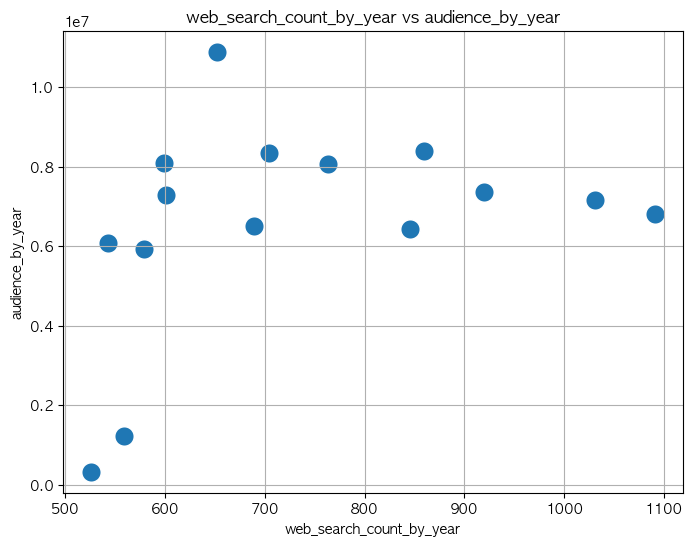

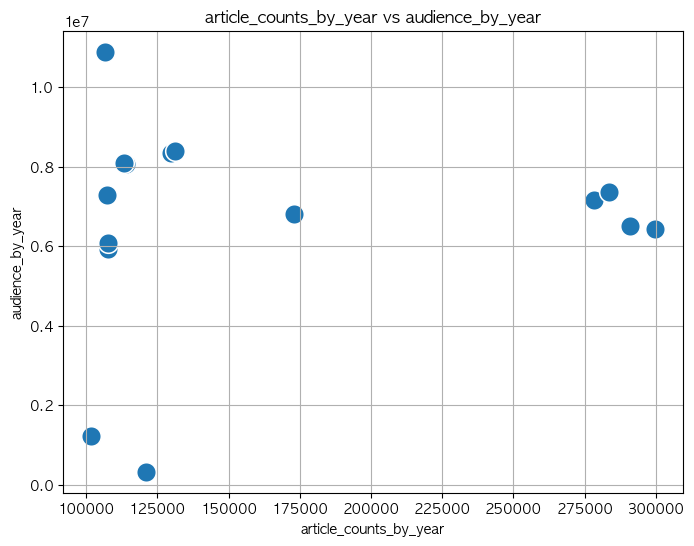

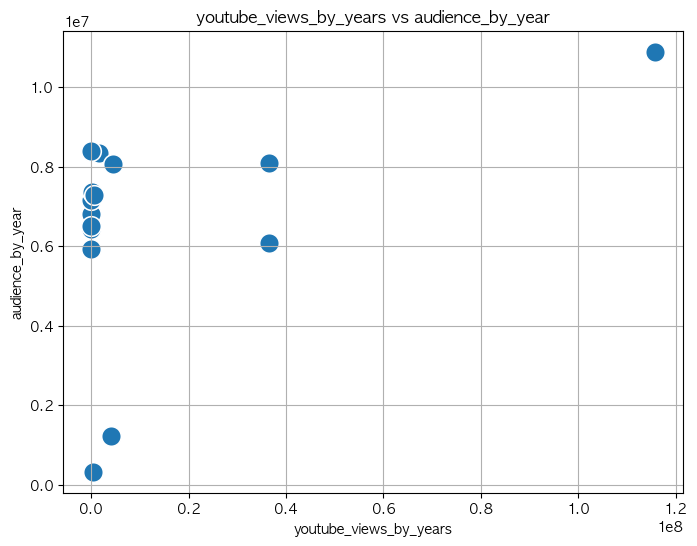

In [12]:
# 산점도 시각화 함수
def plot_scatter(df, x_col, y_col):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=x_col, y=y_col, s=200)
    plt.title(f'{x_col} vs {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True)
    plt.show()

# 독립변수와 종속변수 간 산점도
df = pd.read_csv('./baseball_popularity_by_years.csv')
plot_scatter(df, 'web_search_count_by_year', 'audience_by_year')  # 웹 검색량 vs 관중수
plot_scatter(df, 'article_counts_by_year', 'audience_by_year')  # 기사 개수 vs 관중수
plot_scatter(df, 'youtube_views_by_years', 'audience_by_year')  # 유튜브 조회수 vs 관중수

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

data = pd.read_csv('./baseball_popularity_by_years.csv')

# 타겟과 피쳐 정의
target = ['audience_by_year']
feature = ['article_counts_by_year', 'web_search_count_by_year', 'youtube_views_by_years', 'youtube_likes_by_years', 'youtube_comments_by_years']

X = data[feature]
y = data[target] 

# 타겟 변수 로그 변환
y_log = np.log1p(y)  # 로그 변환 (log(1 + y)로 음수 값 방지)

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_log, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_scaled, y_log)

y_pred = rf_model.predict(X_test)

mean_squared_error(y_test, y_pred, squared=True)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.07167542183187658

In [5]:
pip install statsmodels



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
from statsmodels.tsa.stattools import grangercausalitytests


data = pd.read_csv('./by_teams_baseball_popularity.csv')

# Granger 인과관계 분석을 위한 함수 정의
def granger_analysis_by_team(data, team, dependent_var, independent_vars, max_lag=1):
    """
    Perform Granger causality test for a given team.
    
    Parameters:
    - data: The full dataset
    - team: Team name to filter
    - dependent_var: The dependent variable for Granger analysis
    - independent_vars: List of independent variables to test
    - max_lag: Maximum lag for Granger causality test
    
    Returns:
    - Dictionary of Granger test results
    """
    team_data = data[data['team'] == team]
    data_cleaned = team_data[[dependent_var] + independent_vars].replace(0, np.nan).dropna()
    
    results = {}
    for var in independent_vars:
        if len(data_cleaned) > max_lag:
            try:
                results[var] = grangercausalitytests(
                    data_cleaned[[dependent_var, var]], maxlag=max_lag, verbose=False
                )
            except Exception as e:
                results[var] = str(e)
        else:
            results[var] = "Insufficient observations"
    return results

# Define parameters
teams = data['team'].unique()
dependent_variable = 'audience_counts_by_teams'
independent_variables = [
    'article_count', 'web_search_count', 'youtube_views', 'youtube_likes', 'youtube_comments', 'ranking'
]

# Perform Granger analysis for each team
team_granger_results = {team: granger_analysis_by_team(data, team, dependent_variable, independent_variables) for team in teams}

team_granger_results



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since fu

{'HT': {'article_count': {1: ({'ssr_ftest': (0.08928028081602697,
      0.7845963188342923,
      3.0,
      1),
     'ssr_chi2test': (0.17856056163205394, 0.6726132004653127, 1),
     'lrtest': (0.175955137691858, 0.6748726257437565, 1),
     'params_ftest': (0.0892802808160244, 0.784596318834295, 3.0, 1.0)},
     array([[0., 1., 0.]])])},
  'web_search_count': {1: ({'ssr_ftest': (0.35297661831311866,
      0.5942552100779682,
      3.0,
      1),
     'ssr_chi2test': (0.7059532366262373, 0.40079052155879547, 1),
     'lrtest': (0.6674172325706991, 0.4139535290726645, 1),
     'params_ftest': (0.3529766183131196, 0.5942552100779679, 3.0, 1.0)},
     array([[0., 1., 0.]])])},
  'youtube_views': {1: ({'ssr_ftest': (0.11860397922918009,
      0.7532813009267647,
      3.0,
      1),
     'ssr_chi2test': (0.23720795845836015, 0.6262299870079853, 1),
     'lrtest': (0.23263902279745707, 0.6295738997017029, 1),
     'params_ftest': (0.11860397923029721, 0.7532813009256616, 3.0, 1.0)},
     